# Interpolation Testbed Notebook

Short notebook to test various interpolation strategies. 

In [1]:
import sys 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor

import xarray as xr

In [2]:
sys.path.insert(1, '../sealsml')

In [3]:
from baseline import create_meshgrid, find_closest_values_with_indices, nanargmax_to_one, remove_zero_rows
from baseline import ScipyInterpolate, GaussianProcessInterpolator, RandomForestInterpolator

## Loading in real data

Since none of these need to be 'trained', if it works on one dataset, it will work on all of them. 

In [4]:
data = '../data/training_data_SBL2m_Ug10_src10kg_b.0.nc'

In [5]:
ds = xr.open_dataset(data)
ds

<xarray.Dataset>
Dimensions:         (variable: 8, sample: 600, sensor: 10, time: 100, mask: 2,
                     pot_leak: 20, target_time: 1, sensor_loc: 3)
Coordinates:
  * variable        (variable) object 'ref_distance' 'ref_azi_sin' ... 'q_CH4'
  * sensor_loc      (sensor_loc) object 'xPos' 'yPos' 'zPos'
Dimensions without coordinates: sample, sensor, time, mask, pot_leak,
                                target_time
Data variables:
    encoder_input   (sample, sensor, time, variable, mask) float64 ...
    decoder_input   (sample, pot_leak, target_time, variable, mask) float64 ...
    target          (sample, pot_leak, target_time) float64 ...
    sensor_meta     (sample, sensor, sensor_loc) float64 ...
    leak_meta       (sample, pot_leak, sensor_loc) float64 ...
    met_sensor_loc  (sample, sensor_loc) float64 ...

## Dataset Exploration

This seems bad:

In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter out ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [7]:


# Create an empty list to store reshaped_gp_results
all_reshaped_gp_results = []
leak_loc = []
leak_number = []

number_of_sensors = []
number_of_leaks = []


for i in ds.sample.values:
    # print('sample number', i)

    sensor_locations = remove_zero_rows(ds.sensor_meta.isel(sample=i).values)
    num_of_sensors = sensor_locations.shape[0]
   

    leak_locations = remove_zero_rows(ds.leak_meta.isel(sample=i).values)
    num_of_leaks = leak_locations.shape[0]

    ch4_data = ds.encoder_input.isel(sample=i, sensor=slice(0, num_of_sensors), mask=0).sel(variable='q_CH4').values
    # We are going to take the median. Could also take the P80, etc. Most sensors are either on or off.
    ch4_median = np.median(ch4_data, axis=1)

    ## Create a new mesh ##
    x_new, y_new = create_meshgrid(sensor_locations[:,0], sensor_locations[:,1], buffer=20, grid_points=100)
    # new mesh data points
    X_test = np.column_stack((x_new.ravel(), y_new.ravel()))

    X_train = np.column_stack((sensor_locations[:,0], sensor_locations[:,1]))
    y_train = ch4_median

    ## Make the model
    gp_mo = GaussianProcessInterpolator(length_scale=10, n_restarts_optimizer=10, normalize_y=True) # this needs to be small to not barf
    gp_mo.fit(X_train, y_train)

    # Fit it - Interpolated Results
    reshaped_gp_results = gp_mo.predict(X_test)

    # Let's find the leak locations, and then mark that with a 1
    closest_values_x, indicies_x = find_closest_values_with_indices(leak_locations[:,0], x_new.diagonal())
    closest_values_y, indicies_y = find_closest_values_with_indices(leak_locations[:,1], y_new.diagonal())
    gp_    = reshaped_gp_results[indicies_x, indicies_y]
    
    # need to pad to 20 to match leak locations
    padded_array = np.pad(nanargmax_to_one(gp_), (0, 20 - len(nanargmax_to_one(gp_))), mode='constant')

    # let's also store what sensor is leaking:
    where_padded_one = np.where(padded_array == 1)


    # append it
    number_of_sensors.append(num_of_sensors)
    number_of_leaks.append(num_of_leaks)
    
    leak_number.append(np.asarray(where_padded_one)[0][0])

    leak_loc.append(padded_array)
    all_reshaped_gp_results.append(reshaped_gp_results)

## Some Data Explortation

(array([142.,  42.,  47.,  56.,  43.,  51.,  33.,  33.,  32.,  23.,   0.,
         22.,  20.,  16.,   8.,   7.,  11.,   4.,   7.,   1.,   2.]),
 array([ 0.        ,  0.9047619 ,  1.80952381,  2.71428571,  3.61904762,
         4.52380952,  5.42857143,  6.33333333,  7.23809524,  8.14285714,
         9.04761905,  9.95238095, 10.85714286, 11.76190476, 12.66666667,
        13.57142857, 14.47619048, 15.38095238, 16.28571429, 17.19047619,
        18.0952381 , 19.        ]),
 <BarContainer object of 21 artists>)

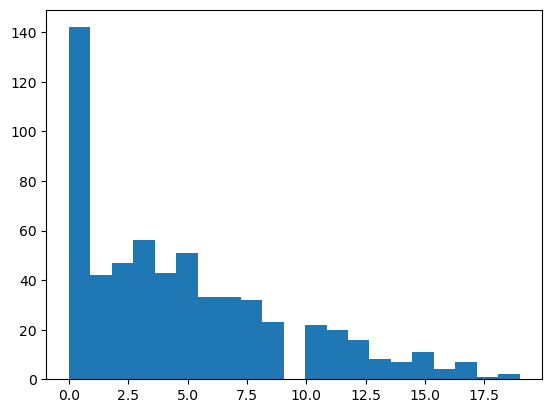

In [8]:
plt.hist(leak_number, bins=21)

(array([77., 30., 70., 38., 67., 41., 85., 40., 64., 88.]),
 array([ 5. ,  6.5,  8. ,  9.5, 11. , 12.5, 14. , 15.5, 17. , 18.5, 20. ]),
 <BarContainer object of 10 artists>)

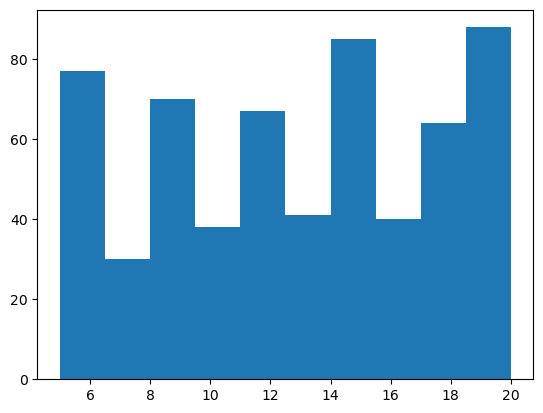

In [9]:
plt.hist(np.asarray(number_of_leaks))

(array([ 84.,   0.,  98.,   0.,  96.,   0., 104.,   0., 110., 108.]),
 array([ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 10 artists>)

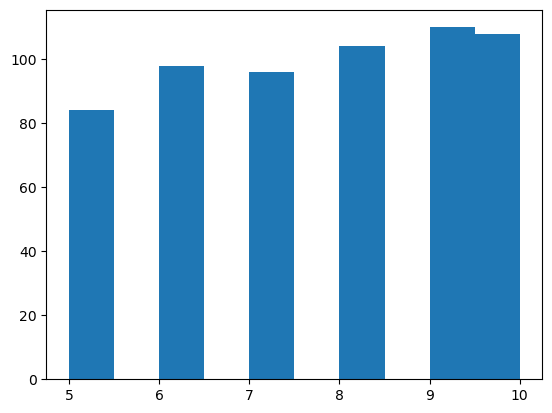

In [10]:
plt.hist(np.asarray(number_of_sensors))